# 라이브러리

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 준비

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/번천/dataset/train_data.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/번천/dataset/test_data.csv')

In [4]:
raw_data.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [5]:
raw_data['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [6]:
raw_test['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64

In [7]:
## 공기압축기가 돌아가는 순서로 열 새롭게 구성

train_data = raw_data[['air_inflow', 'motor_rpm', 'motor_current', 'motor_vibe', 'motor_temp',  'out_pressure', 'air_end_temp', 'type']].copy()
test_data = raw_test[['air_inflow', 'motor_rpm', 'motor_current', 'motor_vibe', 'motor_temp',  'out_pressure', 'air_end_temp', 'type']].copy()

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

In [8]:
hp30 = [0, 4, 5, 6, 7]
hp20 = [1]
hp10 = [2]
hp50 = [3]

In [9]:
# 설비별 데이터 세트 분리

train_data_30hp = train_data[train_data['type'].isin(hp30)].copy()
train_data_20hp = train_data[train_data['type'].isin(hp20)].copy()
train_data_10hp = train_data[train_data['type'].isin(hp10)].copy()
train_data_50hp = train_data[train_data['type'].isin(hp50)].copy()

In [10]:
# 설비별 데이터 세트 분리

test_data_30hp = test_data[test_data['type'].isin(hp30)].copy()
test_data_20hp = test_data[test_data['type'].isin(hp20)].copy()
test_data_10hp = test_data[test_data['type'].isin(hp10)].copy()
test_data_50hp = test_data[test_data['type'].isin(hp50)].copy()

# 모델 생성과 함수 설정

In [11]:
# # define the autoencoder network model
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(16, activation='relu', return_sequences=True, 
#               kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)    
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [12]:
# 모델 구조
timesteps = 7
n_features = 1
layer_1 = 64
layer_2 = 32

# seed 고정
seed = 123

In [13]:
class lstm_ae(tf.keras.Model):
  def __init__(self, timesteps, n_features, layer_1, layer_2):
    super(lstm_ae).__init__()
    self.n_features = n_features
    self.timesteps = timesteps
    self.layer_1 = layer_1
    self.layer_2 = layer_2


  def encoder(self, x):
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = False)(x)
    en_output = layers.RepeatVector(self.timesteps)(x)
    return en_output

  def decoder(self, x):
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    de_output = layers.TimeDistributed(layers.Dense(self.n_features))(x)

    return de_output

  def build(self):
    inputs = Input(shape = (self.timesteps, self.n_features))
    encoder = self.encoder(inputs)
    decoder = self.decoder(encoder)

    return Model(inputs, decoder)

In [14]:
# lstm 구조에 맞게 데이터 변형하는 함수

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [15]:
## 평행 좌표 그리는 함수

def parallel(for_view, num):
  parallel_coordinates(frame = for_view[for_view['type'].isin(num)], class_column = 'type', colormap = plt.get_cmap('Set1'));

In [16]:
## 모델 평가를 위해 3차원을 2차원으로 줄임

def flatten(X):
    flattened_X = X.reshape(X.shape[0], -1)
    return flattened_X

In [17]:
## timestep 3 이기 때문에 처음 두 개의 데이터에 대한 가정

def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

# 경로 설정

In [18]:
# 현재 폴더 경로 지정
PATH = '/content/drive/MyDrive/번천/모델 9'
os.chdir(PATH)
os.getcwd()

'/content/drive/MyDrive/번천/모델 9'

# hp30

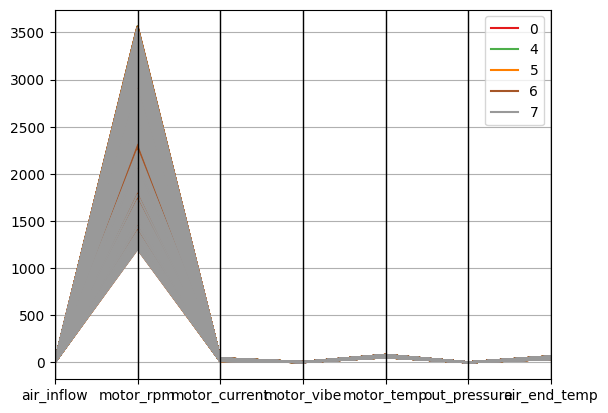

In [ ]:
parallel(train_data, hp30)

## 첫 번째 모델

In [30]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화


full_data_30hp = pd.concat([test_data_30hp, train_data_30hp], ignore_index = True)
scaler_30hp.fit(full_data_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))
train_scale_30hp = scaler_30hp.transform(train_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [31]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./30hp_history.npy',history.history)

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.2503
Epoch 1: val_loss improved from inf to 0.12103, saving model to ./모델 저장/30hp.h5
40/40 [==============================] - 9s 46ms/step - loss: 0.2503 - val_loss: 0.1210 - lr: 0.0010
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 0.1041
Epoch 2: val_loss improved from 0.12103 to 0.08329, saving model to ./모델 저장/30hp.h5
40/40 [==============================] - 1s 24ms/step - loss: 0.1041 - val_loss: 0.0833 - lr: 0.0010
Epoch 3/300
40/40 [==============================] - ETA: 0s - loss: 0.0653
Epoch 3: val_loss improved from 0.08329 to 0.04786, saving model to ./모델 저장/30hp.h5
40/40 [==============================] - 1s 23ms/step - loss: 0.0653 - val_loss: 0.0479 - lr: 0.0010
Epoch 4/300
39/40 [============================>.] - ETA: 0s - loss: 0.0425
Epoch 4: val_loss improved from 0.04786 to 0.04053, saving model to ./모델 저장/30hp.h5
40/40 [==============================

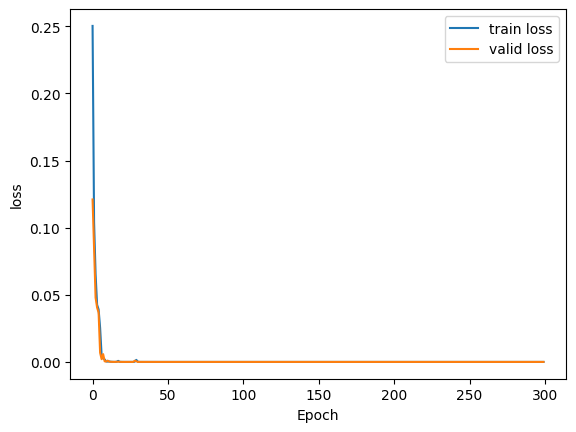

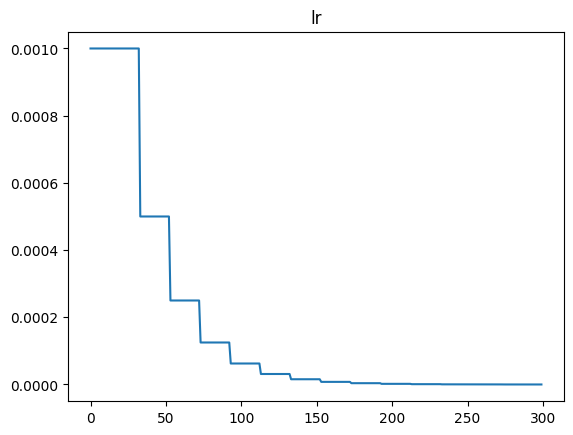

In [32]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장/30hp.h5')
history = history=np.load('./30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [33]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 1s 6ms/step
293


In [ ]:
# plt.figure(figsize = (15,5));
# plt.plot(np.sort(test_mse_30hp)[-291:])
# plt.ylim(0,0.003)

# anom_30hp = test_mse_30hp > np.sort(test_mse_30hp)[-291]

# # pred 데이터 생성
# pred_30hp = test_data_30hp.copy()
# pred_30hp['y'] = anom_30hp

# # 개수 확인
# print(np.sum(anom_30hp))

290


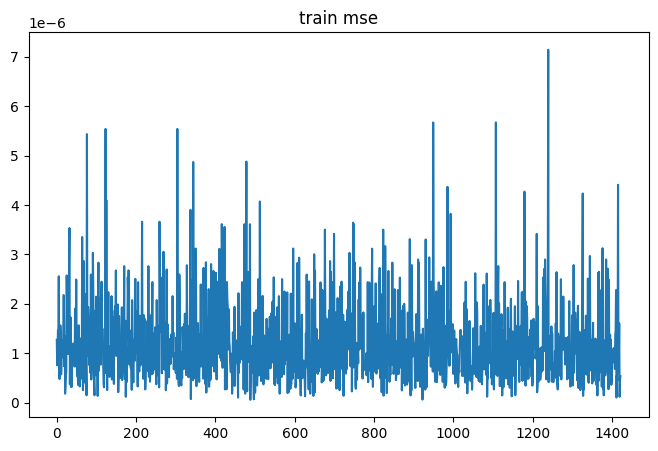

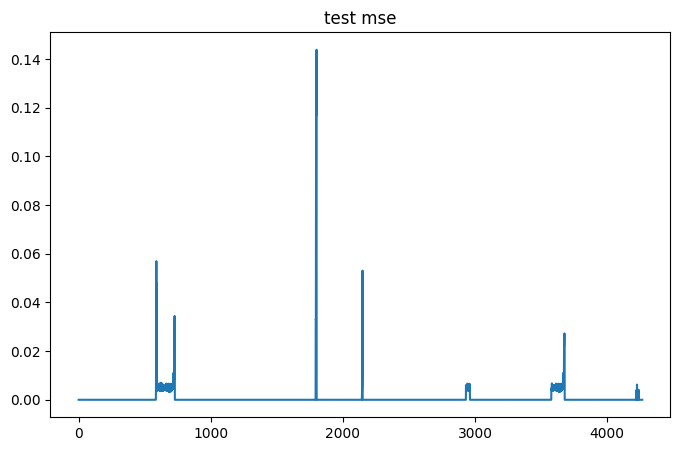

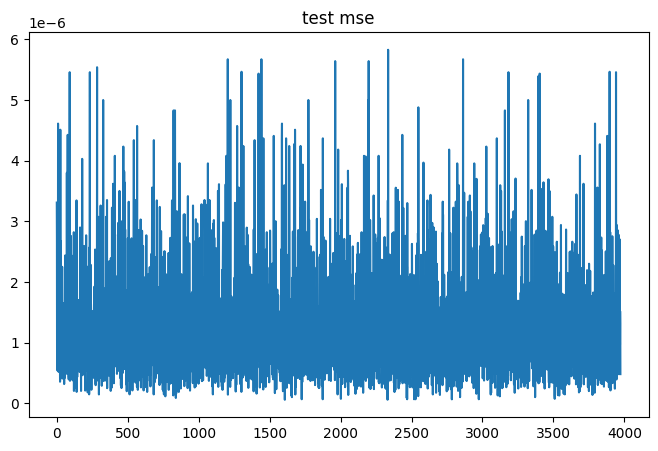

In [34]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp[~anom_30hp]);
plt.title('test mse');

## 두 번째 모델

In [35]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_30hp = test_data_30hp[test_mse_30hp < (np.mean(train_mse_30hp) + np.std(train_mse_30hp))].copy()
new_train_30hp = pd.concat([train_data_30hp, for_new_train_30hp], ignore_index = True) 

In [42]:
new_train_30hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_30hp.csv')

In [37]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_30hp = pd.concat([test_data_30hp, train_data_30hp], ignore_index = True)
scaler_30hp.fit(full_data_30hp.drop(['type'], axis=1))
train_scale_30hp = scaler_30hp.transform(new_train_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [38]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/30hp_history.npy',history.history)

Epoch 1/300
135/135 [==============================] - ETA: 0s - loss: 0.1276
Epoch 1: val_loss improved from inf to 0.05148, saving model to ./모델 저장2/30hp.h5
135/135 [==============================] - 11s 27ms/step - loss: 0.1276 - val_loss: 0.0515 - lr: 0.0010
Epoch 2/300
134/135 [============================>.] - ETA: 0s - loss: 0.0411
Epoch 2: val_loss improved from 0.05148 to 0.03871, saving model to ./모델 저장2/30hp.h5
135/135 [==============================] - 3s 22ms/step - loss: 0.0410 - val_loss: 0.0387 - lr: 0.0010
Epoch 3/300
135/135 [==============================] - ETA: 0s - loss: 0.0198
Epoch 3: val_loss improved from 0.03871 to 0.00060, saving model to ./모델 저장2/30hp.h5
135/135 [==============================] - 3s 24ms/step - loss: 0.0198 - val_loss: 6.0092e-04 - lr: 0.0010
Epoch 4/300
133/135 [============================>.] - ETA: 0s - loss: 2.0157e-04
Epoch 4: val_loss improved from 0.00060 to 0.00006, saving model to ./모델 저장2/30hp.h5
135/135 [=

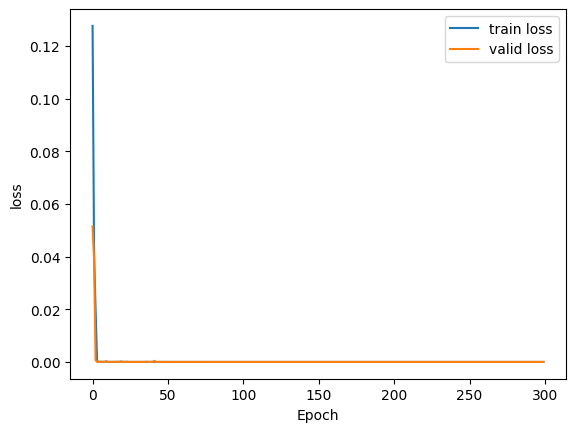

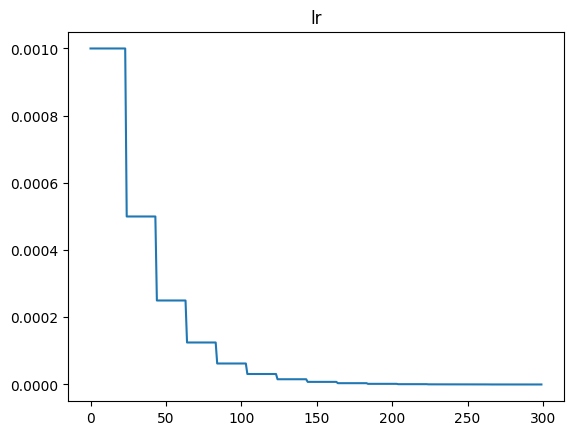

In [39]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장2/30hp.h5')
history = history=np.load('./history2/30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [40]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 1s 7ms/step
291


In [ ]:
anom_30hp = test_mse_30hp > np.mean(train_mse_30hp) + 10*np.std(train_mse_30hp)

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

325


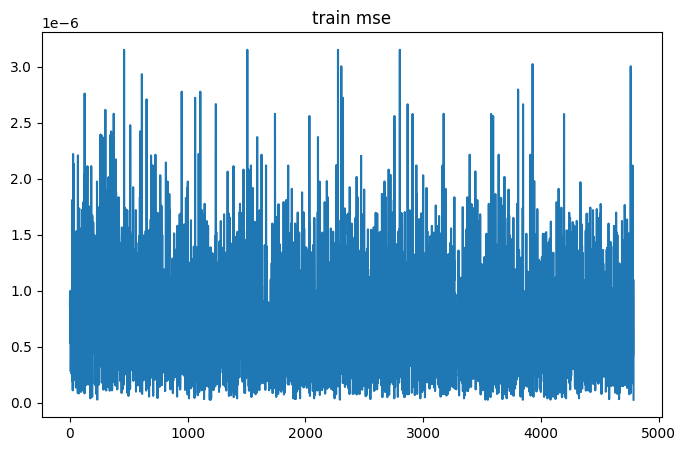

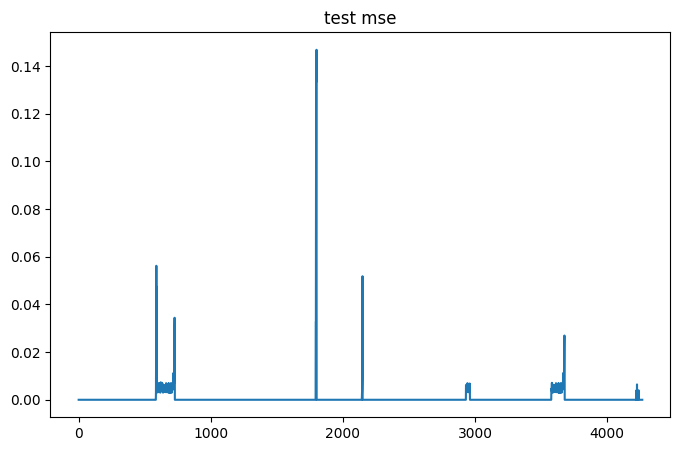

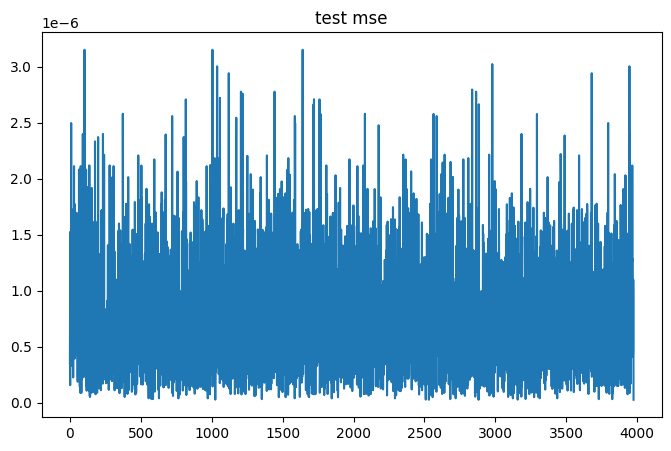

In [41]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp[~anom_30hp]);
plt.title('test mse');

# hp20

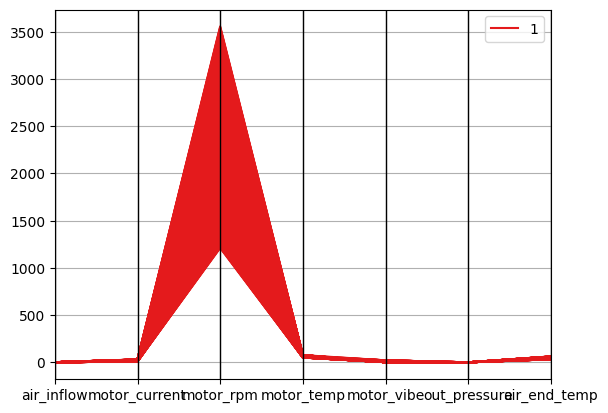

In [ ]:
parallel(train_data, hp20)

## 첫 번째 모델

In [44]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [46]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./20hp_history.npy',history.history)

Epoch 1/200
10/11 [==========================>...] - ETA: 0s - loss: 0.2123
Epoch 1: val_loss improved from inf to 0.17451, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 7s 112ms/step - loss: 0.2109 - val_loss: 0.1745 - lr: 0.0010
Epoch 2/200
10/11 [==========================>...] - ETA: 0s - loss: 0.1810
Epoch 2: val_loss improved from 0.17451 to 0.13781, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 0s 32ms/step - loss: 0.1776 - val_loss: 0.1378 - lr: 0.0010
Epoch 3/200
10/11 [==========================>...] - ETA: 0s - loss: 0.1385
Epoch 3: val_loss improved from 0.13781 to 0.12303, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 0s 32ms/step - loss: 0.1373 - val_loss: 0.1230 - lr: 0.0010
Epoch 4/200
 9/11 [=======================>......] - ETA: 0s - loss: 0.1275
Epoch 4: val_loss improved from 0.12303 to 0.11384, saving model to ./모델 저장/20hp.h5
11/11 [=============================

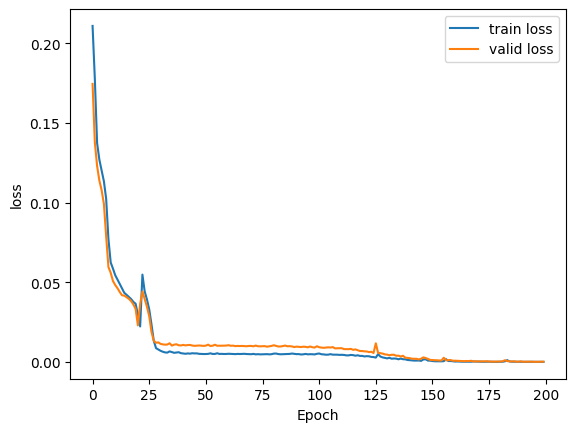

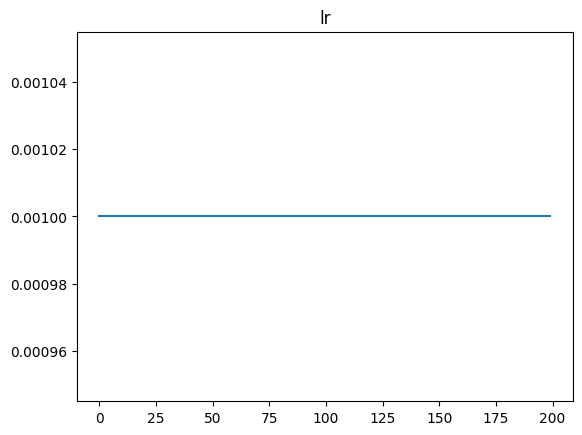

In [47]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장/20hp.h5')
history = history=np.load('./20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [48]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 7ms/step
0


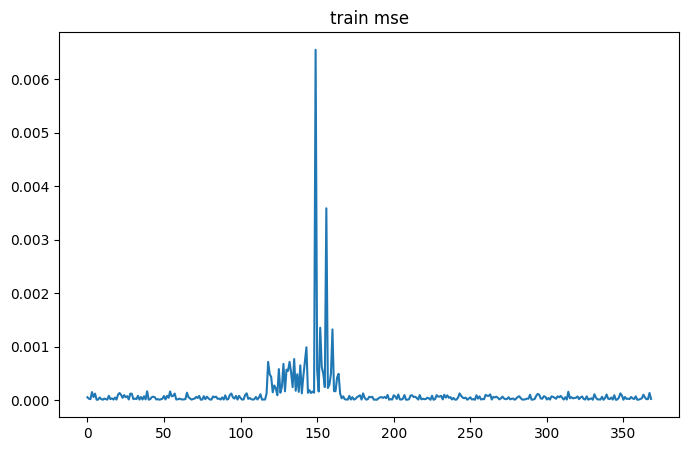

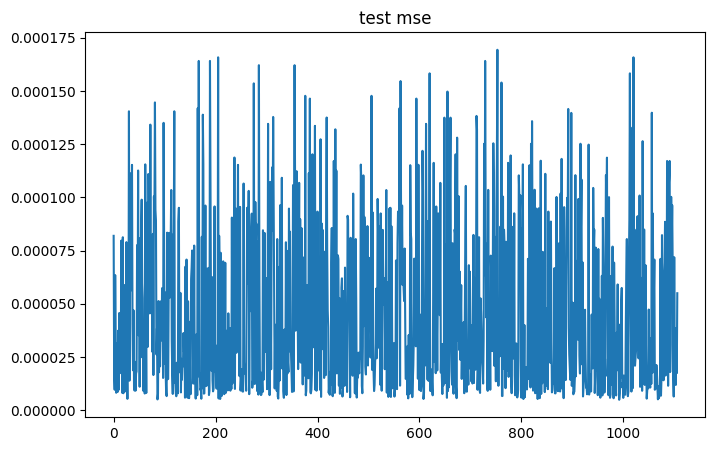

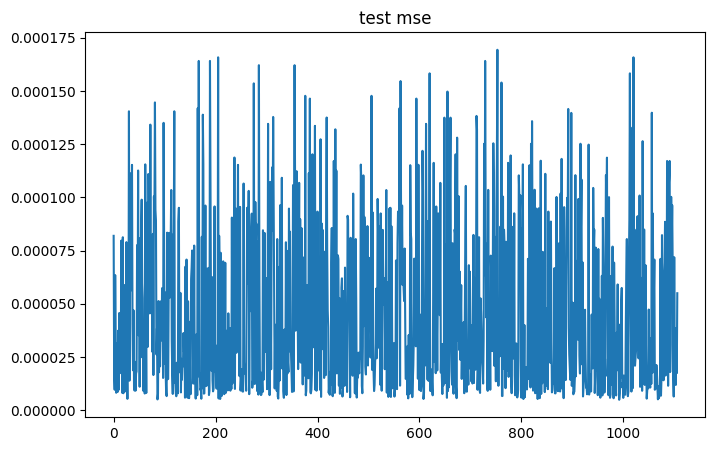

In [49]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

## 두 번째 모델

In [50]:
## test mse가 test mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용


train_cut_20hp = train_data_20hp[train_mse_20hp < np.max(test_mse_20hp)].copy()
for_new_train_20hp = test_data_20hp[test_mse_20hp < (np.mean(test_mse_20hp) + np.std(test_mse_20hp))].copy()
new_train_20hp = pd.concat([train_cut_20hp, for_new_train_20hp], ignore_index = True)

In [28]:
# new_train_20hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_20hp.csv')

new_train_20hp = pd.read_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_20hp.csv', index_col = 0)


In [30]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(new_train_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/20hp_history.npy',history.history)

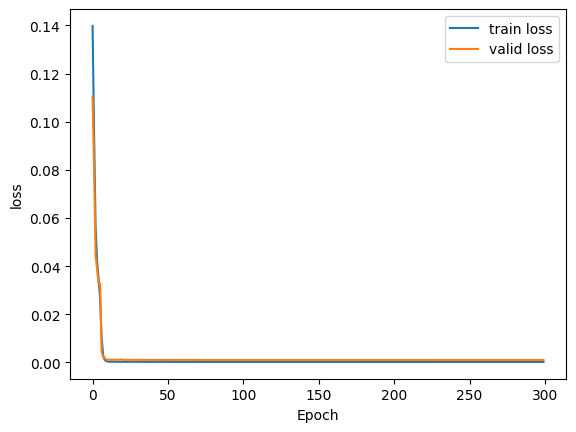

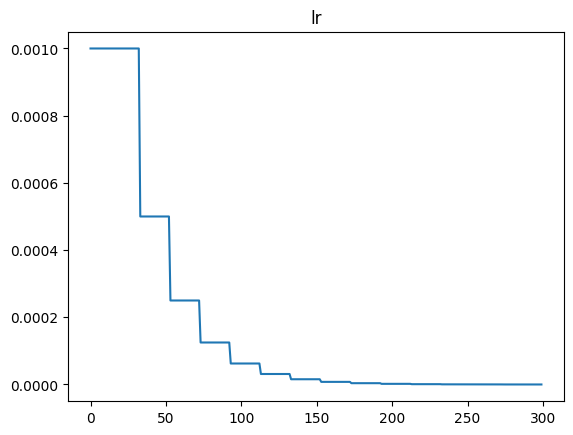

In [31]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장2/20hp.h5')
history = history=np.load('./history2/20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [32]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 6ms/step
0


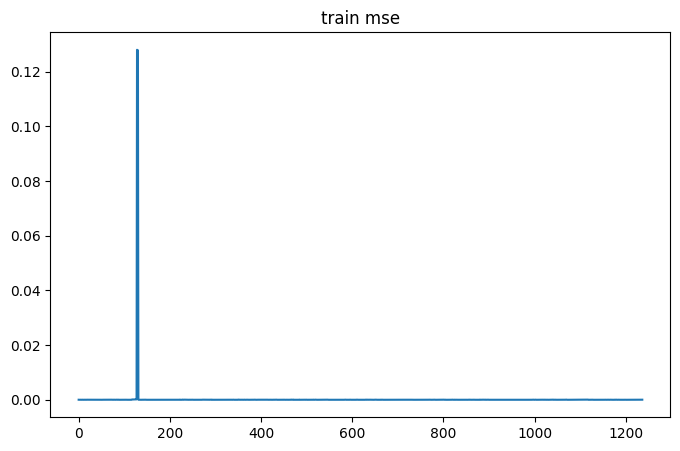

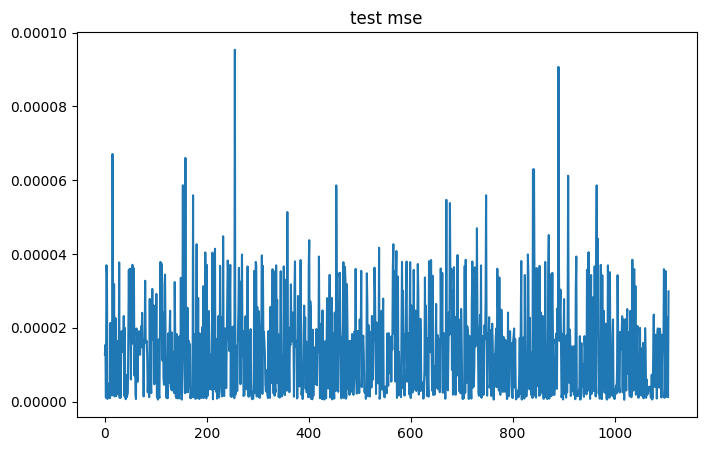

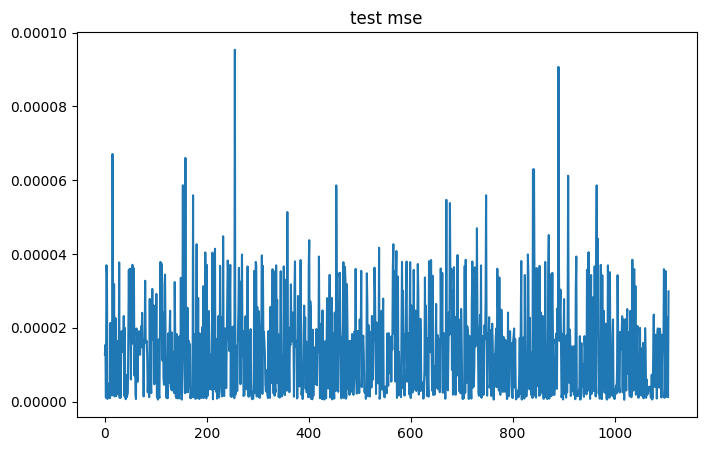

In [33]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

## 세 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용


train_cut2_20hp = train_cut_20hp[train_mse_20hp < np.max(test_mse_20hp)].copy()
train_cut2_20hp
# for_new_train_20hp = test_data_20hp[test_mse_20hp < (np.mean(train_mse_20hp) + np.std(train_mse_20hp))].copy()
# new_train_20hp = pd.concat([train_data_20hp, for_new_train_20hp], ignore_index = True) 

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
432,1.73,25.60,2973.0,71.03,3.45,0.7,55.16,1
433,1.31,19.32,2244.0,62.93,3.05,0.7,46.05,1
434,1.33,19.69,2287.0,63.41,3.07,0.7,46.59,1
435,1.87,27.56,3200.0,73.56,3.58,0.7,58.00,1
436,1.68,24.78,2878.0,69.98,3.40,0.7,53.98,1
...,...,...,...,...,...,...,...,...
796,0.72,10.56,1226.0,51.62,2.48,0.7,33.33,1
797,0.86,12.68,1473.0,54.37,2.62,0.7,36.41,1
798,0.83,12.31,1430.0,53.89,2.59,0.7,35.88,1
799,1.77,26.07,3028.0,71.64,3.48,0.7,55.85,1


In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_cut2_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장3/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history3/20hp_history.npy',history.history)

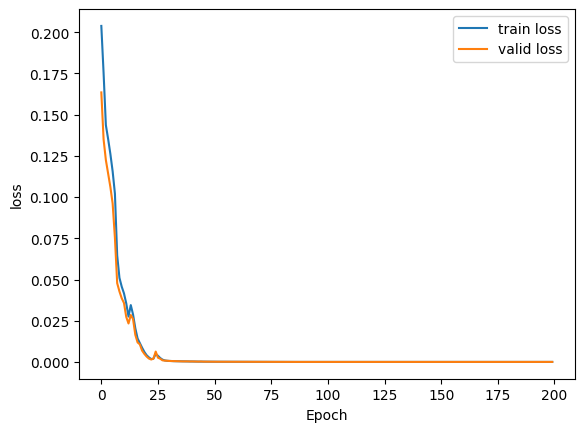

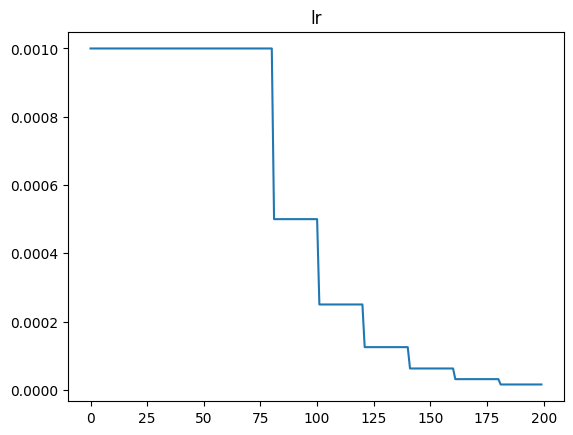

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장3/20hp.h5')
history = history=np.load('./history3/20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 6ms/step
4


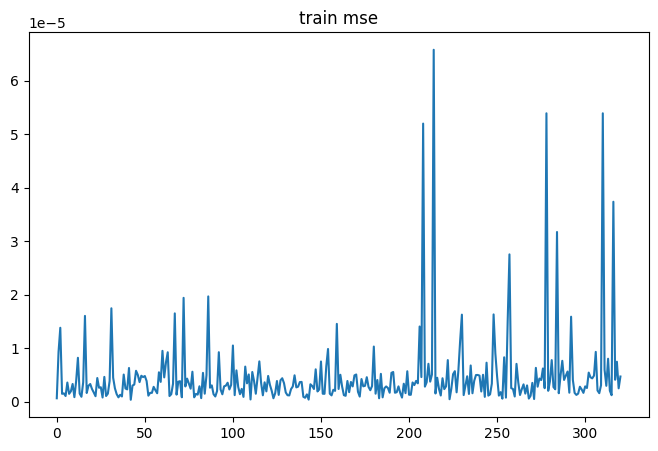

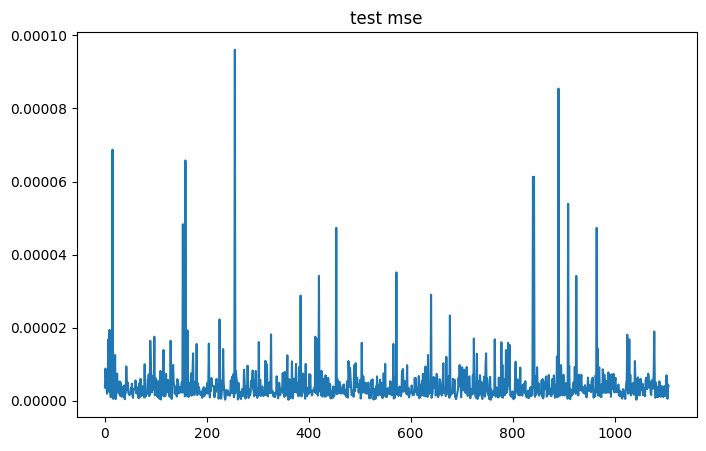

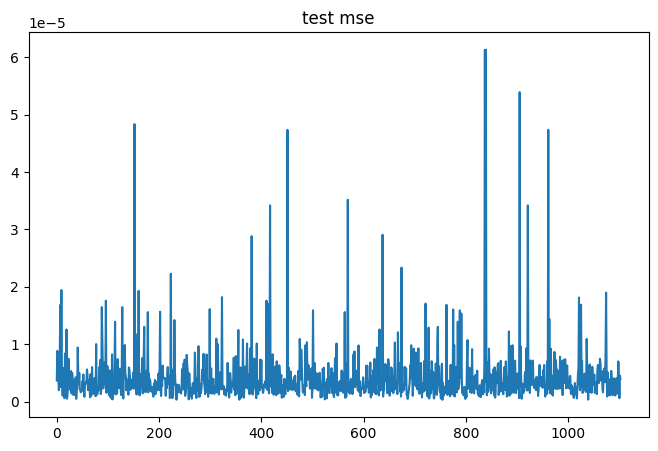

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

# hp10


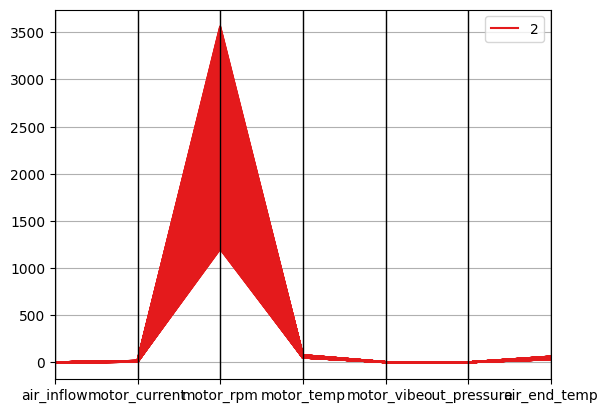

In [ ]:
parallel(train_data, hp10)

In [57]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_10hp = pd.concat([test_data_10hp, train_data_10hp], ignore_index = True)
scaler_10hp.fit(full_data_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))
train_scale_10hp = scaler_10hp.transform(train_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [58]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./10hp_history.npy',history.history)

Epoch 1/300
10/11 [==========================>...] - ETA: 0s - loss: 0.2505
Epoch 1: val_loss improved from inf to 0.19487, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 10s 131ms/step - loss: 0.2482 - val_loss: 0.1949 - lr: 0.0010
Epoch 2/300
10/11 [==========================>...] - ETA: 0s - loss: 0.2073
Epoch 2: val_loss improved from 0.19487 to 0.14962, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 0s 32ms/step - loss: 0.2075 - val_loss: 0.1496 - lr: 0.0010
Epoch 3/300
10/11 [==========================>...] - ETA: 0s - loss: 0.1546
Epoch 3: val_loss improved from 0.14962 to 0.12986, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 0s 35ms/step - loss: 0.1534 - val_loss: 0.1299 - lr: 0.0010
Epoch 4/300
 9/11 [=======================>......] - ETA: 0s - loss: 0.1323
Epoch 4: val_loss improved from 0.12986 to 0.11116, saving model to ./모델 저장/10hp.h5
11/11 [============================

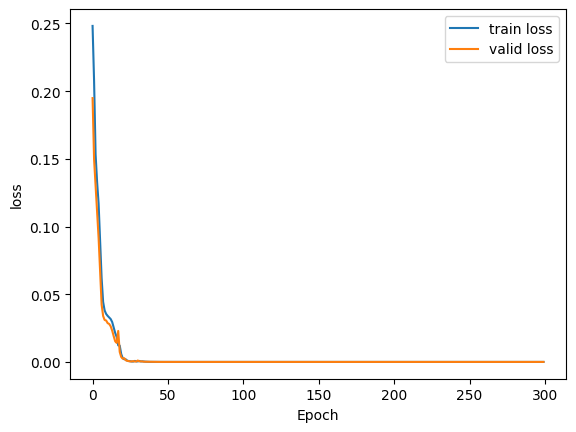

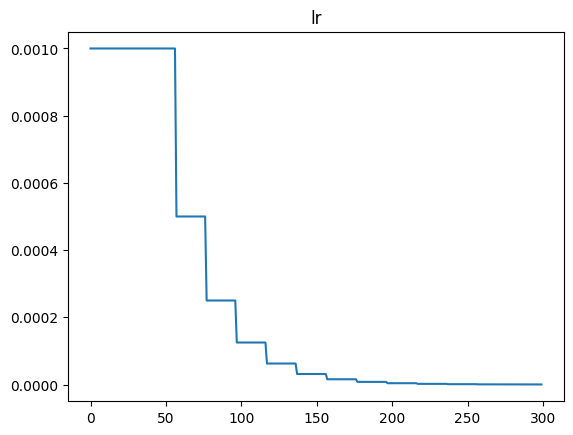

In [59]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장/10hp.h5')
history = history=np.load('./10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [60]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 7ms/step
27


In [ ]:
anom_10hp = test_mse_10hp > np.mean(train_mse_10hp) + 100*np.std(train_mse_10hp)

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

NameError: ignored

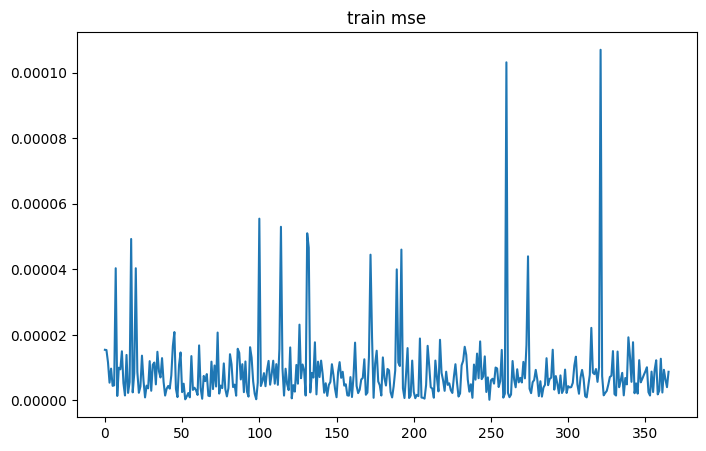

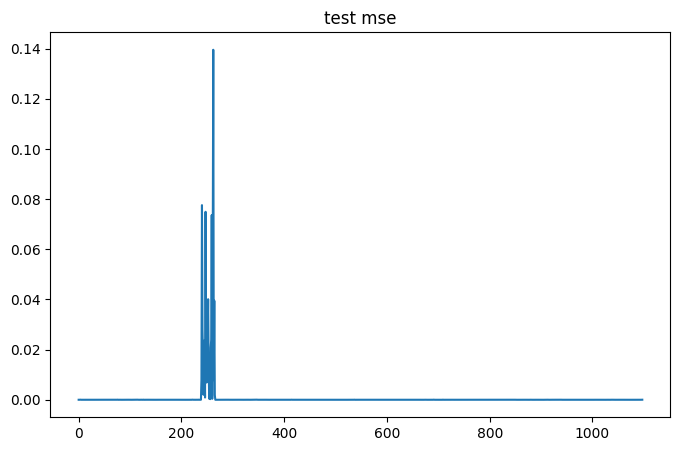

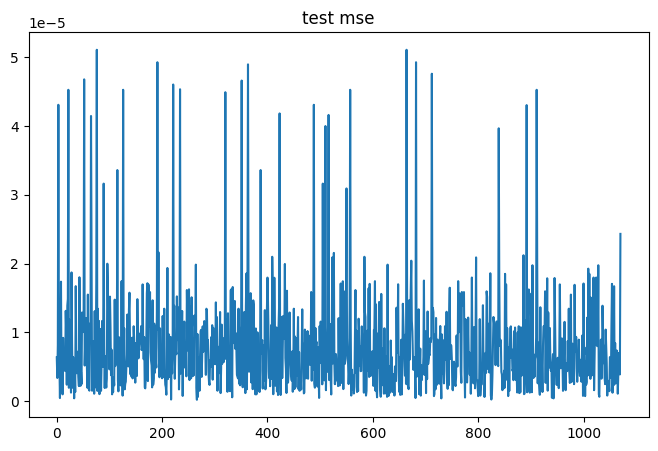

In [61]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp[~anom_10hp]);
plt.title('test mse');

## 두 번째 모델

In [62]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_10hp = test_data_10hp[test_mse_10hp < (np.mean(train_mse_10hp) + np.std(train_mse_10hp))].copy()
new_train_10hp = pd.concat([train_data_10hp, for_new_train_10hp], ignore_index = True) 

In [63]:
new_train_10hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_10hp.csv')

In [64]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_10hp = pd.concat([test_data_10hp, train_data_10hp], ignore_index = True)
scaler_10hp.fit(full_data_10hp.drop(['type'], axis=1))
train_scale_10hp = scaler_10hp.transform(new_train_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [65]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/10hp_history.npy',history.history)

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.1919
Epoch 1: val_loss improved from inf to 0.12421, saving model to ./모델 저장2/10hp.h5
40/40 [==============================] - 10s 49ms/step - loss: 0.1919 - val_loss: 0.1242 - lr: 0.0010
Epoch 2/300
39/40 [============================>.] - ETA: 0s - loss: 0.1022
Epoch 2: val_loss improved from 0.12421 to 0.04909, saving model to ./모델 저장2/10hp.h5
40/40 [==============================] - 1s 28ms/step - loss: 0.1020 - val_loss: 0.0491 - lr: 0.0010
Epoch 3/300
39/40 [============================>.] - ETA: 0s - loss: 0.0406
Epoch 3: val_loss improved from 0.04909 to 0.03288, saving model to ./모델 저장2/10hp.h5
40/40 [==============================] - 1s 27ms/step - loss: 0.0406 - val_loss: 0.0329 - lr: 0.0010
Epoch 4/300
38/40 [===========================>..] - ETA: 0s - loss: 0.0348
Epoch 4: val_loss improved from 0.03288 to 0.03048, saving model to ./모델 저장2/10hp.h5
40/40 [=========================

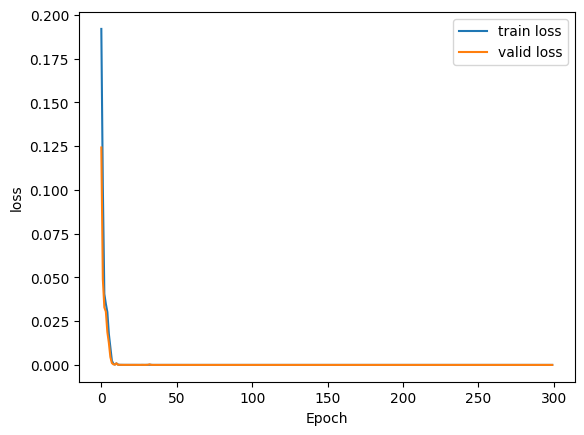

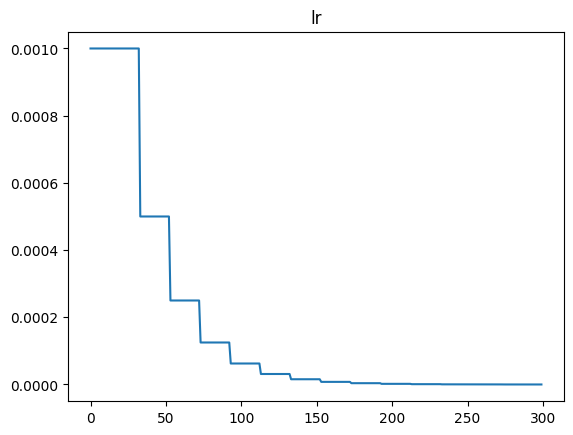

In [66]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장2/10hp.h5')
history = history=np.load('./history2/10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [67]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 9ms/step
27


In [ ]:
anom_10hp = test_mse_10hp > np.mean(train_mse_10hp) + 10*np.std(train_mse_10hp)

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

27


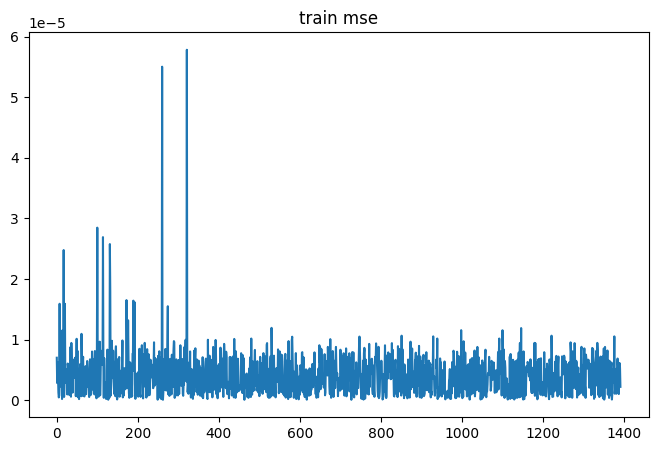

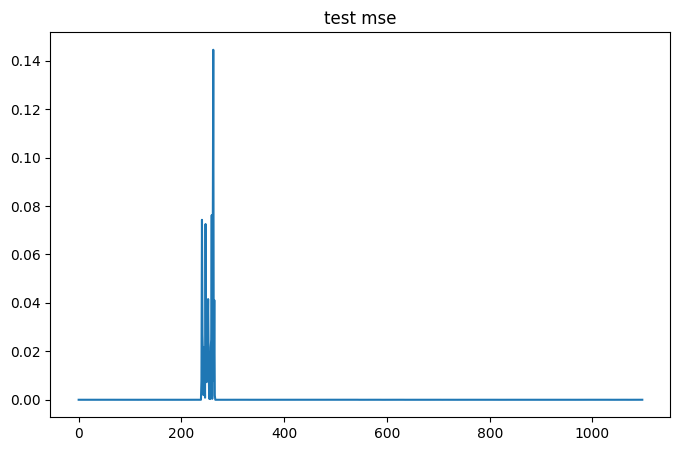

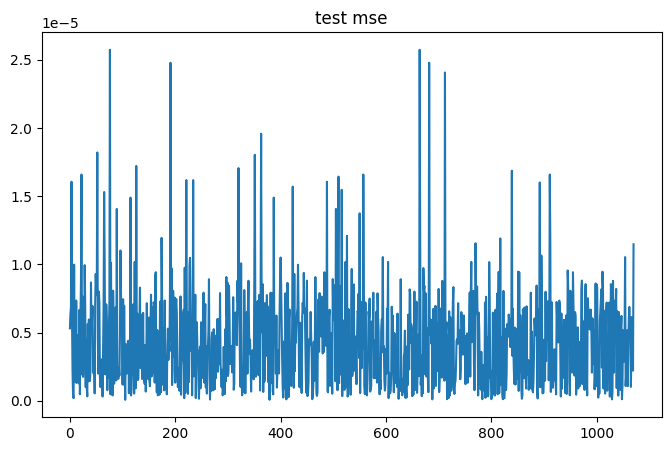

In [69]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp[~anom_10hp]);
plt.title('test mse');

# hp50

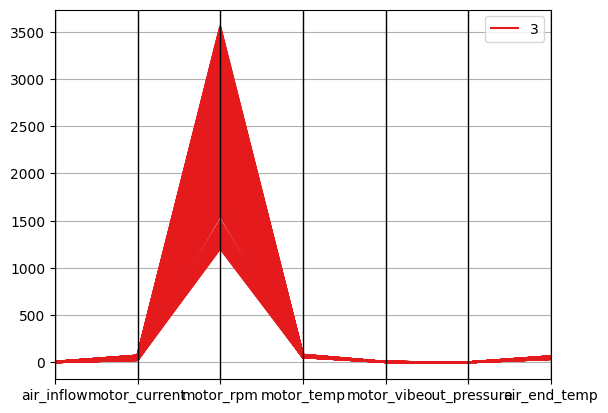

In [ ]:
parallel(train_data, hp50)

In [37]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_50hp = pd.concat([test_data_50hp, train_data_50hp], ignore_index = True)
scaler_50hp.fit(full_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))
train_scale_50hp = scaler_50hp.transform(train_data_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [71]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./50hp_history.npy',history.history)

Epoch 1/300
9/9 [==============================] - ETA: 0s - loss: 0.2421
Epoch 1: val_loss improved from inf to 0.31444, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 8s 162ms/step - loss: 0.2421 - val_loss: 0.3144 - lr: 0.0010
Epoch 2/300
7/9 [======================>.......] - ETA: 0s - loss: 0.2079
Epoch 2: val_loss improved from 0.31444 to 0.25547, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 32ms/step - loss: 0.2076 - val_loss: 0.2555 - lr: 0.0010
Epoch 3/300
9/9 [==============================] - ETA: 0s - loss: 0.1559
Epoch 3: val_loss improved from 0.25547 to 0.19005, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 35ms/step - loss: 0.1559 - val_loss: 0.1900 - lr: 0.0010
Epoch 4/300
7/9 [======================>.......] - ETA: 0s - loss: 0.1422
Epoch 4: val_loss improved from 0.19005 to 0.18422, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 34ms/ste

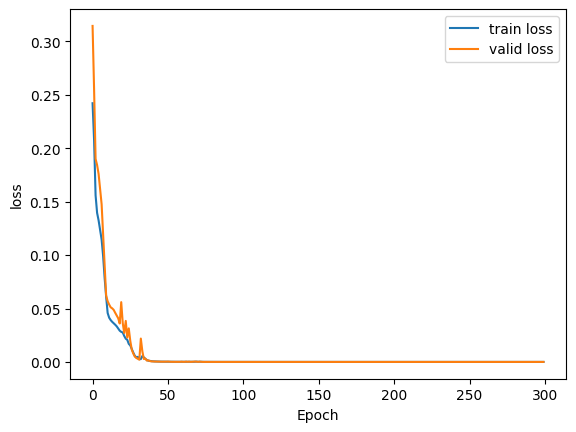

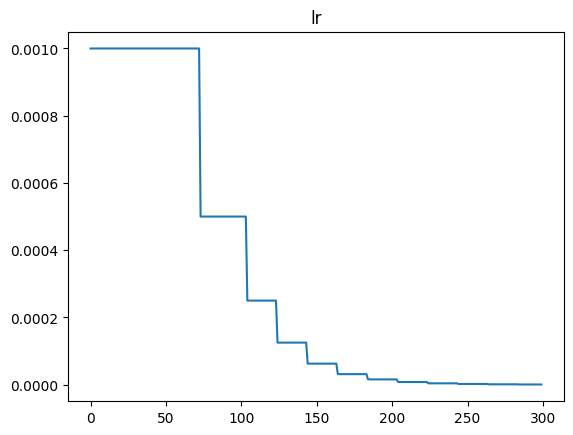

In [38]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장/50hp.h5')
history = history=np.load('./50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [39]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 6ms/step
28


In [74]:
anom_50hp = test_mse_50hp > np.mean(train_mse_50hp) + 100*np.std(train_mse_50hp)

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

25


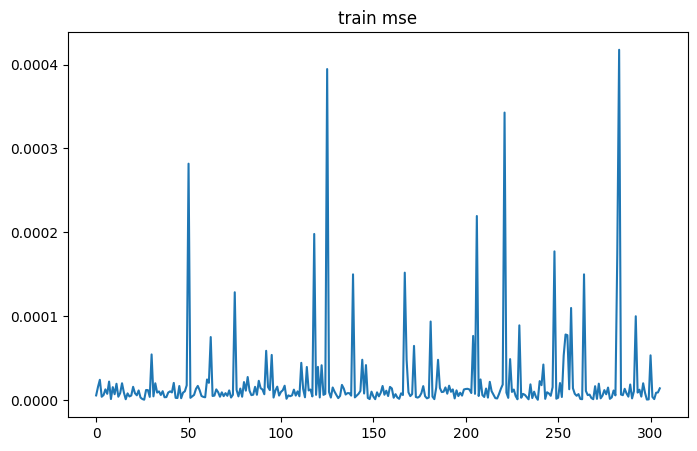

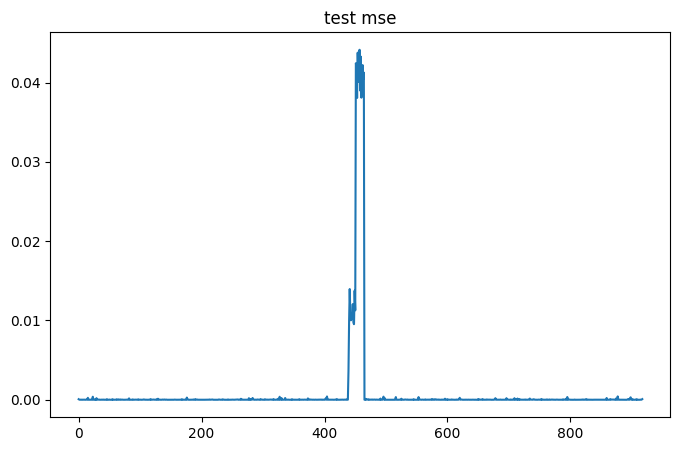

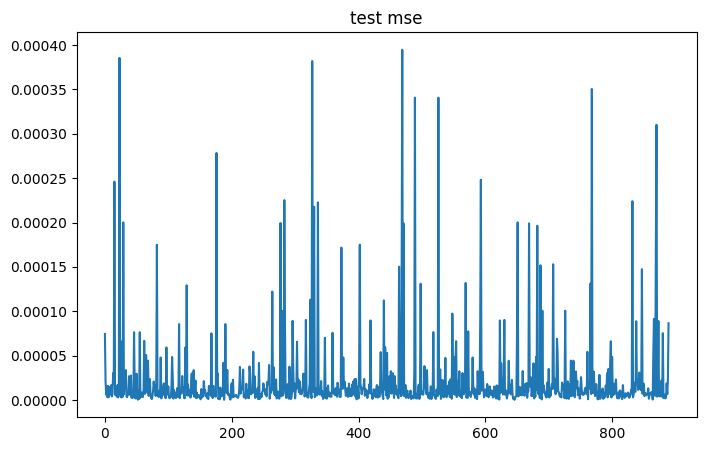

In [40]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp[~anom_50hp]);
plt.title('test mse');

## 두 번째 모델

In [41]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_50hp = test_data_50hp[test_mse_50hp < (np.mean(train_mse_50hp) + np.std(train_mse_50hp))].copy()
new_train_50hp = pd.concat([train_data_50hp, for_new_train_50hp], ignore_index = True) 

In [42]:
new_train_50hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_50hp.csv')

In [79]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_50hp = pd.concat([test_data_50hp, train_data_50hp], ignore_index = True)
scaler_50hp.fit(full_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))
train_scale_50hp = scaler_50hp.transform(new_train_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [81]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/50hp_history.npy',history.history)

Epoch 1/300
31/32 [============================>.] - ETA: 0s - loss: 0.1998
Epoch 1: val_loss improved from inf to 0.15248, saving model to ./모델 저장2/50hp.h5
32/32 [==============================] - 8s 73ms/step - loss: 0.1985 - val_loss: 0.1525 - lr: 0.0010
Epoch 2/300
30/32 [===========================>..] - ETA: 0s - loss: 0.1267
Epoch 2: val_loss improved from 0.15248 to 0.11514, saving model to ./모델 저장2/50hp.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.1256 - val_loss: 0.1151 - lr: 0.0010
Epoch 3/300
30/32 [===========================>..] - ETA: 0s - loss: 0.0742
Epoch 3: val_loss improved from 0.11514 to 0.04381, saving model to ./모델 저장2/50hp.h5
32/32 [==============================] - 1s 24ms/step - loss: 0.0721 - val_loss: 0.0438 - lr: 0.0010
Epoch 4/300
30/32 [===========================>..] - ETA: 0s - loss: 0.0379
Epoch 4: val_loss improved from 0.04381 to 0.03583, saving model to ./모델 저장2/50hp.h5
32/32 [==========================

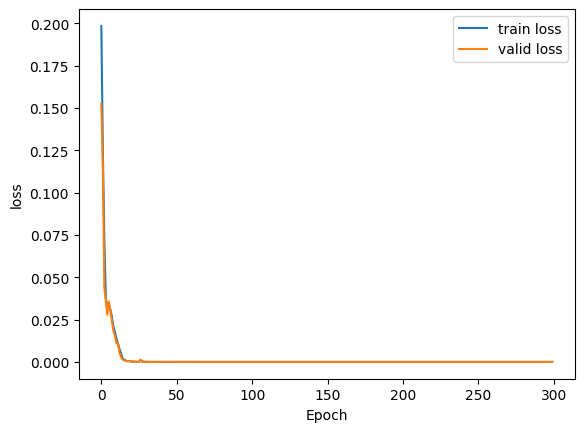

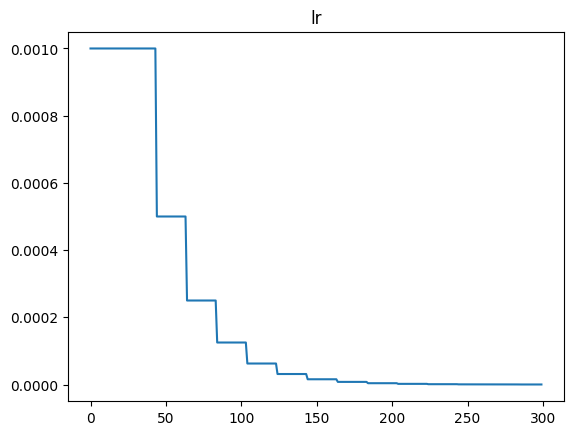

In [82]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장2/50hp.h5')
history = history=np.load('./history2/50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [83]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 9ms/step
27


In [ ]:
anom_50hp = test_mse_50hp > np.mean(train_mse_50hp) + 10*np.std(train_mse_50hp)

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

34


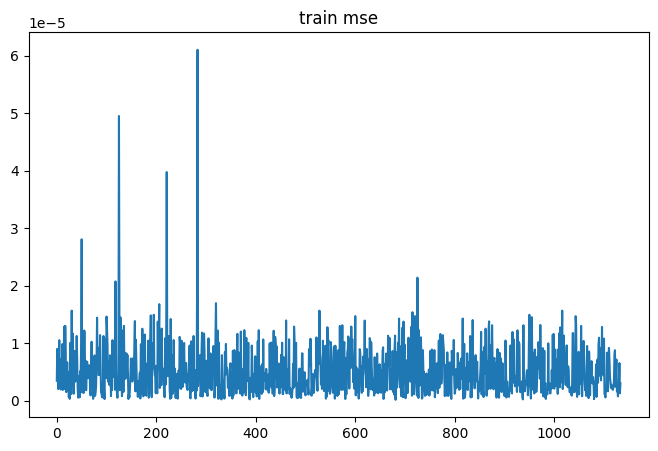

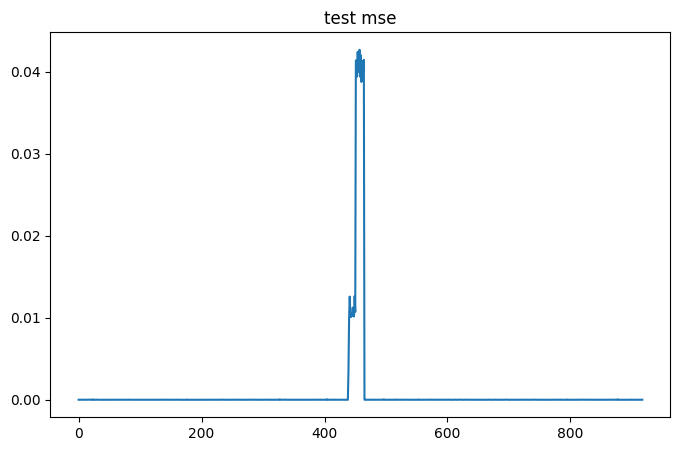

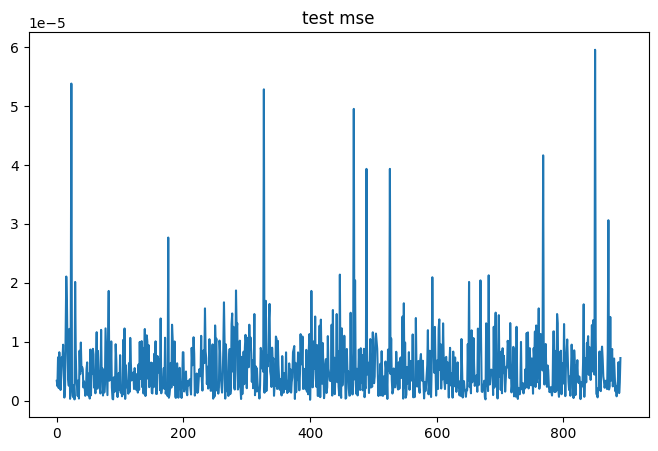

In [84]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp[~anom_50hp]);
plt.title('test mse');

# pred 합치기

test_data_30hp

test_data_20hp

test_data_10hp

test_data_50hp

In [85]:
pred_10hp['y']

2403    False
2404    False
2405    False
2406    False
2407    False
        ...  
3496    False
3497    False
3498    False
3499    False
3500    False
Name: y, Length: 1098, dtype: bool

In [86]:
answer = pd.concat([pred_30hp['y'], pred_20hp['y'], pred_10hp['y'], pred_50hp['y']]).sort_index()
answer = pd.concat([test_data['type'], answer], axis=1)
answer.rename(columns={'y':'label'}, inplace = True)

In [89]:
answer['label'].sum()

345

In [90]:
answer

,type,label
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False
...,...,...
7384,7,False
7385,7,False
7386,7,False
7387,7,False


In [96]:
print(answer['label'][answer['type'].isin(hp30)].sum())
print(answer['label'][answer['type'].isin(hp20)].sum())
print(answer['label'][answer['type'].isin(hp10)].sum())
print(answer['label'][answer['type'].isin(hp50)].sum())

291
0
27
27


In [91]:
answer.to_csv("/content/drive/MyDrive/번천/answer/answer_model_9.csv")